<a href="https://colab.research.google.com/github/LiNdA-jz/cifar10_ann_to_snn/blob/main/cifar10_ann_to_snn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install snntoolbox

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0      

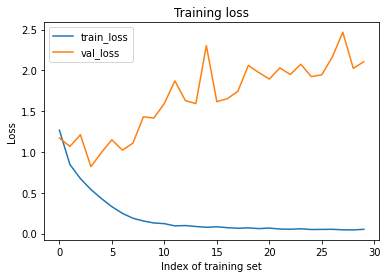

In [2]:
"""End-to-end example for SNN Toolbox.

This script sets up a small CNN using Keras and tensorflow, trains it for one
epoch on MNIST, stores model and dataset in a temporary folder on disk, creates
a configuration file for SNN toolbox, and finally calls the main function of
SNN toolbox to convert the trained ANN to an SNN and run it using INI
simulator.
"""

import os
import time
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Input, Model, datasets, layers, models
from tensorflow.keras.utils import to_categorical

from snntoolbox.bin.run import main
from snntoolbox.utils.utils import import_configparser

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping

# WORKING DIRECTORY #
#####################

# Define path where model and output files will be stored.
# The user is responsible for cleaning up this temporary directory.
# path_wd = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath(
#     __file__)), 'temp', str(time.time())))
path_wd = "gdrive/MyDrive/30040/output/" + str(time.time())
os.makedirs(path_wd)

# GET DATASET #
###############

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0


y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Save dataset so SNN toolbox can find it.
np.savez_compressed(os.path.join(path_wd, 'x_test'), x_test)
np.savez_compressed(os.path.join(path_wd, 'y_test'), y_test)
# SNN toolbox will not do any training, but we save a subset of the training
# set so the toolbox can use it when normalizing the network parameters.
np.savez_compressed(os.path.join(path_wd, 'x_norm'), x_train[::10])

# ANN
model = models.Sequential()
# dimension of output, kernel size
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

axis = 1 if keras.backend.image_data_format() == 'channels_first' else -1
# pool size
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.BatchNormalization(axis=axis))

model.summary()

# dense takes 1D vector
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(64))
# model.add(layers.ReLU())
# CIFAR has 10 classes
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# early stopping callback if no improvement in loss
es = EarlyStopping(monitor='loss', 
                    min_delta=0.05,
                    mode='max', # don't minimize the accuracy!
                    patience=10,
                    restore_best_weights=True)

model_fit = model.fit(x_train, y_train, batch_size=64, epochs=30, 
                    validation_data=(x_test, y_test))
                    # callbacks=[es])

# plot graph for loss
train_loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epoch = range(0,len(model_fit.history['loss']),1)
plt.figure()
plt.plot()
plt.plot(epoch, train_loss, label='train_loss')
plt.plot(epoch, val_loss, label='val_loss')
plt.legend()
plt.title('Training loss')
plt.xlabel('Index of training set')
plt.ylabel('Loss')
plt.show()

# Store model so SNN Toolbox can find it.
model_name = 'cifar10_cnn'
keras.models.save_model(model, os.path.join(path_wd, model_name + '.h5'))



In [3]:
!pip install brian2

In [ ]:
# path_wd = '/content/gdrive/MyDrive/30040/output/1639674077.1328545'

# model_name = 'cifar10_cnn'

# SNN TOOLBOX CONFIGURATION #
#############################

# Create a config file with experimental setup for SNN Toolbox.
configparser = import_configparser()
config = configparser.ConfigParser()

config['paths'] = {
    'path_wd': path_wd,             # Path to model.
    'dataset_path': path_wd,        # Path to dataset.
    'filename_ann': model_name      # Name of input model.
}

config['input'] = {
    # 'model_lib': 'keras',
    'poisson_input': True          # Images are encodes as spike trains.
}

config['tools'] = {
    'evaluateAnn': True,            # Test ANN on dataset before conversion.
    # 'parse': True,
    'normalize': True               # Normalize weights for full dynamic range.
    # 'convert': True
}

config['normalization'] = {
    'percentile': 99.9,
    'normalization_schedule': True
}

config['conversion'] = {
    # 'softmax_to_relu': True,
    'maxpool_type': 'avg_max'
    # 'spike_code': 'ttfs_dyn_thresh'
}

config['simulation'] = {
    'simulator': 'brian2',          # Chooses execution backend of SNN toolbox.
    'duration': 50,                 # Number of time steps to run each sample.
    'dt': 10,                       # Time resolution for ODE solving.
    'num_to_test': 100,             # How many test samples to run.
    'batch_size': 1,                # Batch size for simulation.
    'top_k': 5
}

config['cell'] = {
    # 'v_thresh': 0.6,
    'reset': 'Reset by subtraction'    
}

config['output'] = {
    'plot_vars': {                  # Various plots (slows down simulation).
        'activations',
        'spiketrains',              # Leave section empty to turn off plots.
        'spikerates',
        'error_t',
        'correlation',
        # 'v_mem',
        }
}

# Store config file.
config_filepath = os.path.join(path_wd, 'config')
with open(config_filepath, 'w') as configfile:
    config.write(configfile)

# RUN SNN TOOLBOX #
###################

main(config_filepath)


Initializing brian2 simulator...

Loading data set from '.npz' files in /content/gdrive/MyDrive/30040/output/1645578334.3569741.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                          

WARNING    /usr/local/lib/python3.7/dist-packages/snntoolbox/simulation/utils.py:1828: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])
 [py.warnings]


Top-1 accuracy: 60.00%
Top-5 accuracy: 92.00%

Building spiking model...
Building layer: 00Conv2D_30x30x32
Transposing kernels.
................................
Connecting layer...
Building layer: 01Conv2D_28x28x32
Transposing kernels.
................................
Connecting layer...


WARNING    /usr/local/lib/python3.7/dist-packages/snntoolbox/simulation/utils.py:1479: RuntimeWarning: Layer type 'MaxPooling' not supported yet. Falling back on 'AveragePooling'.
  "Falling back on 'AveragePooling'.", RuntimeWarning)
 [py.warnings]


Building layer: 02MaxPooling2D_14x14x32
................................
Building layer: 03Conv2D_12x12x64
Transposing kernels.
................................................................
Connecting layer...
Building layer: 04Conv2D_10x10x64
Transposing kernels.
................................................................
Connecting layer...
Building layer: 05MaxPooling2D_5x5x64
................................................................
Building layer: 06Flatten_1600
Building layer: 07Dense_512
Swapping data_format of Flatten layer.
Building layer: 08Dense_10
Compiling spiking model...

Detected layer with biases: 00Conv2D_30x30x32
Detected layer with biases: 01Conv2D_28x28x32
Detected layer with biases: 03Conv2D_12x12x64
Detected layer with biases: 04Conv2D_10x10x64
Detected layer with biases: 07Dense_512
Detected layer with biases: 08Dense_10
Number of operations of ANN: 30405770
Number of neurons: 77898
Number of synapses: 18956032

Saving weights ...
Store weights of

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 2 of 100 completed (2.0%)
Moving accuracy of SNN (top-1, top-5): 0.00%, 0.00%.
Moving accuracy of ANN (top-1, top-5): 50.00%, 100.00%.

Calculating activations...

Average spike rate: 0.18051377053229592 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer 0

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 3 of 100 completed (3.0%)
Moving accuracy of SNN (top-1, top-5): 0.00%, 0.00%.
Moving accuracy of ANN (top-1, top-5): 33.33%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer 0

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 4 of 100 completed (4.0%)
Moving accuracy of SNN (top-1, top-5): 25.00%, 25.00%.
Moving accuracy of ANN (top-1, top-5): 50.00%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 5 of 100 completed (5.0%)
Moving accuracy of SNN (top-1, top-5): 20.00%, 40.00%.
Moving accuracy of ANN (top-1, top-5): 60.00%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 6 of 100 completed (6.0%)
Moving accuracy of SNN (top-1, top-5): 16.67%, 50.00%.
Moving accuracy of ANN (top-1, top-5): 66.67%, 100.00%.

Calculating activations...

Average spike rate: 0.17940718784735088 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 7 of 100 completed (7.0%)
Moving accuracy of SNN (top-1, top-5): 14.29%, 42.86%.
Moving accuracy of ANN (top-1, top-5): 71.43%, 100.00%.

Calculating activations...

Average spike rate: 0.179350376682722 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer 0

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 8 of 100 completed (8.0%)
Moving accuracy of SNN (top-1, top-5): 12.50%, 50.00%.
Moving accuracy of ANN (top-1, top-5): 62.50%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 9 of 100 completed (9.0%)
Moving accuracy of SNN (top-1, top-5): 11.11%, 44.44%.
Moving accuracy of ANN (top-1, top-5): 55.56%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 10 of 100 completed (10.0%)
Moving accuracy of SNN (top-1, top-5): 10.00%, 40.00%.
Moving accuracy of ANN (top-1, top-5): 60.00%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 11 of 100 completed (11.0%)
Moving accuracy of SNN (top-1, top-5): 18.18%, 45.45%.
Moving accuracy of ANN (top-1, top-5): 63.64%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 12 of 100 completed (12.0%)
Moving accuracy of SNN (top-1, top-5): 16.67%, 41.67%.
Moving accuracy of ANN (top-1, top-5): 66.67%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 13 of 100 completed (13.0%)
Moving accuracy of SNN (top-1, top-5): 15.38%, 46.15%.
Moving accuracy of ANN (top-1, top-5): 61.54%, 100.00%.

Calculating activations...

Average spike rate: 0.17938495739162652 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 14 of 100 completed (14.0%)
Moving accuracy of SNN (top-1, top-5): 14.29%, 50.00%.
Moving accuracy of ANN (top-1, top-5): 64.29%, 100.00%.

Calculating activations...

Average spike rate: 0.17977028529084846 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 15 of 100 completed (15.0%)
Moving accuracy of SNN (top-1, top-5): 13.33%, 46.67%.
Moving accuracy of ANN (top-1, top-5): 66.67%, 100.00%.

Calculating activations...

Average spike rate: 0.17946399901197974 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 16 of 100 completed (16.0%)
Moving accuracy of SNN (top-1, top-5): 12.50%, 43.75%.
Moving accuracy of ANN (top-1, top-5): 68.75%, 100.00%.

Calculating activations...

Average spike rate: 0.1793454365814499 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 17 of 100 completed (17.0%)
Moving accuracy of SNN (top-1, top-5): 11.76%, 47.06%.
Moving accuracy of ANN (top-1, top-5): 70.59%, 100.00%.

Calculating activations...

Average spike rate: 0.18045942941830306 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 18 of 100 completed (18.0%)
Moving accuracy of SNN (top-1, top-5): 11.11%, 50.00%.
Moving accuracy of ANN (top-1, top-5): 72.22%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 19 of 100 completed (19.0%)
Moving accuracy of SNN (top-1, top-5): 10.53%, 47.37%.
Moving accuracy of ANN (top-1, top-5): 68.42%, 100.00%.

Calculating activations...

Average spike rate: 0.179481289366432 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 20 of 100 completed (20.0%)
Moving accuracy of SNN (top-1, top-5): 10.00%, 50.00%.
Moving accuracy of ANN (top-1, top-5): 70.00%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 21 of 100 completed (21.0%)
Moving accuracy of SNN (top-1, top-5): 9.52%, 52.38%.
Moving accuracy of ANN (top-1, top-5): 71.43%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 22 of 100 completed (22.0%)
Moving accuracy of SNN (top-1, top-5): 13.64%, 54.55%.
Moving accuracy of ANN (top-1, top-5): 72.73%, 100.00%.

Calculating activations...

Average spike rate: 0.18277386686427072 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 23 of 100 completed (23.0%)
Moving accuracy of SNN (top-1, top-5): 13.04%, 56.52%.
Moving accuracy of ANN (top-1, top-5): 69.57%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 24 of 100 completed (24.0%)
Moving accuracy of SNN (top-1, top-5): 12.50%, 54.17%.
Moving accuracy of ANN (top-1, top-5): 70.83%, 100.00%.

Calculating activations...

Average spike rate: 0.18041743855749043 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 25 of 100 completed (25.0%)
Moving accuracy of SNN (top-1, top-5): 12.00%, 56.00%.
Moving accuracy of ANN (top-1, top-5): 72.00%, 100.00%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting lay

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 26 of 100 completed (26.0%)
Moving accuracy of SNN (top-1, top-5): 11.54%, 53.85%.
Moving accuracy of ANN (top-1, top-5): 69.23%, 96.15%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 27 of 100 completed (27.0%)
Moving accuracy of SNN (top-1, top-5): 11.11%, 55.56%.
Moving accuracy of ANN (top-1, top-5): 66.67%, 96.30%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 28 of 100 completed (28.0%)
Moving accuracy of SNN (top-1, top-5): 14.29%, 57.14%.
Moving accuracy of ANN (top-1, top-5): 67.86%, 96.43%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 29 of 100 completed (29.0%)
Moving accuracy of SNN (top-1, top-5): 13.79%, 55.17%.
Moving accuracy of ANN (top-1, top-5): 68.97%, 96.55%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 30 of 100 completed (30.0%)
Moving accuracy of SNN (top-1, top-5): 13.33%, 56.67%.
Moving accuracy of ANN (top-1, top-5): 66.67%, 96.67%.

Calculating activations...

Average spike rate: 0.17928862541682106 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 31 of 100 completed (31.0%)
Moving accuracy of SNN (top-1, top-5): 12.90%, 58.06%.
Moving accuracy of ANN (top-1, top-5): 64.52%, 93.55%.

Calculating activations...

Average spike rate: 0.1794467086575275 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 32 of 100 completed (32.0%)
Moving accuracy of SNN (top-1, top-5): 12.50%, 59.38%.
Moving accuracy of ANN (top-1, top-5): 65.62%, 93.75%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 33 of 100 completed (33.0%)
Moving accuracy of SNN (top-1, top-5): 12.12%, 60.61%.
Moving accuracy of ANN (top-1, top-5): 63.64%, 93.94%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 34 of 100 completed (34.0%)
Moving accuracy of SNN (top-1, top-5): 11.76%, 61.76%.
Moving accuracy of ANN (top-1, top-5): 64.71%, 94.12%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 35 of 100 completed (35.0%)
Moving accuracy of SNN (top-1, top-5): 11.43%, 60.00%.
Moving accuracy of ANN (top-1, top-5): 65.71%, 94.29%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 36 of 100 completed (36.0%)
Moving accuracy of SNN (top-1, top-5): 11.11%, 58.33%.
Moving accuracy of ANN (top-1, top-5): 63.89%, 91.67%.

Calculating activations...

Average spike rate: 0.17986167716438187 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 37 of 100 completed (37.0%)
Moving accuracy of SNN (top-1, top-5): 10.81%, 59.46%.
Moving accuracy of ANN (top-1, top-5): 62.16%, 91.89%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 38 of 100 completed (38.0%)
Moving accuracy of SNN (top-1, top-5): 10.53%, 57.89%.
Moving accuracy of ANN (top-1, top-5): 63.16%, 92.11%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 39 of 100 completed (39.0%)
Moving accuracy of SNN (top-1, top-5): 10.26%, 56.41%.
Moving accuracy of ANN (top-1, top-5): 64.10%, 92.31%.

Calculating activations...

Average spike rate: 0.1793627269359022 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 40 of 100 completed (40.0%)
Moving accuracy of SNN (top-1, top-5): 10.00%, 57.50%.
Moving accuracy of ANN (top-1, top-5): 65.00%, 92.50%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting laye

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 41 of 100 completed (41.0%)
Moving accuracy of SNN (top-1, top-5): 9.76%, 58.54%.
Moving accuracy of ANN (top-1, top-5): 65.85%, 92.68%.

Calculating activations...

Average spike rate: 0.17934790663208597 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 42 of 100 completed (42.0%)
Moving accuracy of SNN (top-1, top-5): 9.52%, 59.52%.
Moving accuracy of ANN (top-1, top-5): 66.67%, 92.86%.

Calculating activations...

Average spike rate: 0.17934296653081389 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
Plotting layer 05MaxPooling2D_5x5x64
Plotting layer 07Dense_512
Plotting layer

WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


Plotting batch run statistics...
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
10. ms (20%) simulated in < 1s, estimated < 1s remaining.
20. ms (40%) simulated in < 1s, estimated < 1s remaining.
30. ms (60%) simulated in < 1s, estimated < 1s remaining.
40. ms (80%) simulated in < 1s, estimated < 1s remaining.
50. ms (100%) simulated in < 1s

Batch 43 of 100 completed (43.0%)
Moving accuracy of SNN (top-1, top-5): 9.30%, 60.47%.
Moving accuracy of ANN (top-1, top-5): 65.12%, 93.02%.

Calculating activations...

Average spike rate: 0.17932814622699766 spikes per simulation time step.
Saving plots of one sample to gdrive/MyDrive/30040/output/1645578334.3569741/log/gui/test...

Plotting layer 00Conv2D_30x30x32
Plotting layer 01Conv2D_28x28x32
Plotting layer 02MaxPooling2D_14x14x32
Plotting layer 03Conv2D_12x12x64
Plotting layer 04Conv2D_10x10x64
